# IMPORT

In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno
import numpy as np
import pandas as pd
import re
import json
pd.options.mode.chained_assignment = None


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
!pip freeze > requirements.txt

In [4]:
random_seed = 42

current_date = pd.to_datetime('30/07/2020')

In [5]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['Rating'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True)

In [7]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


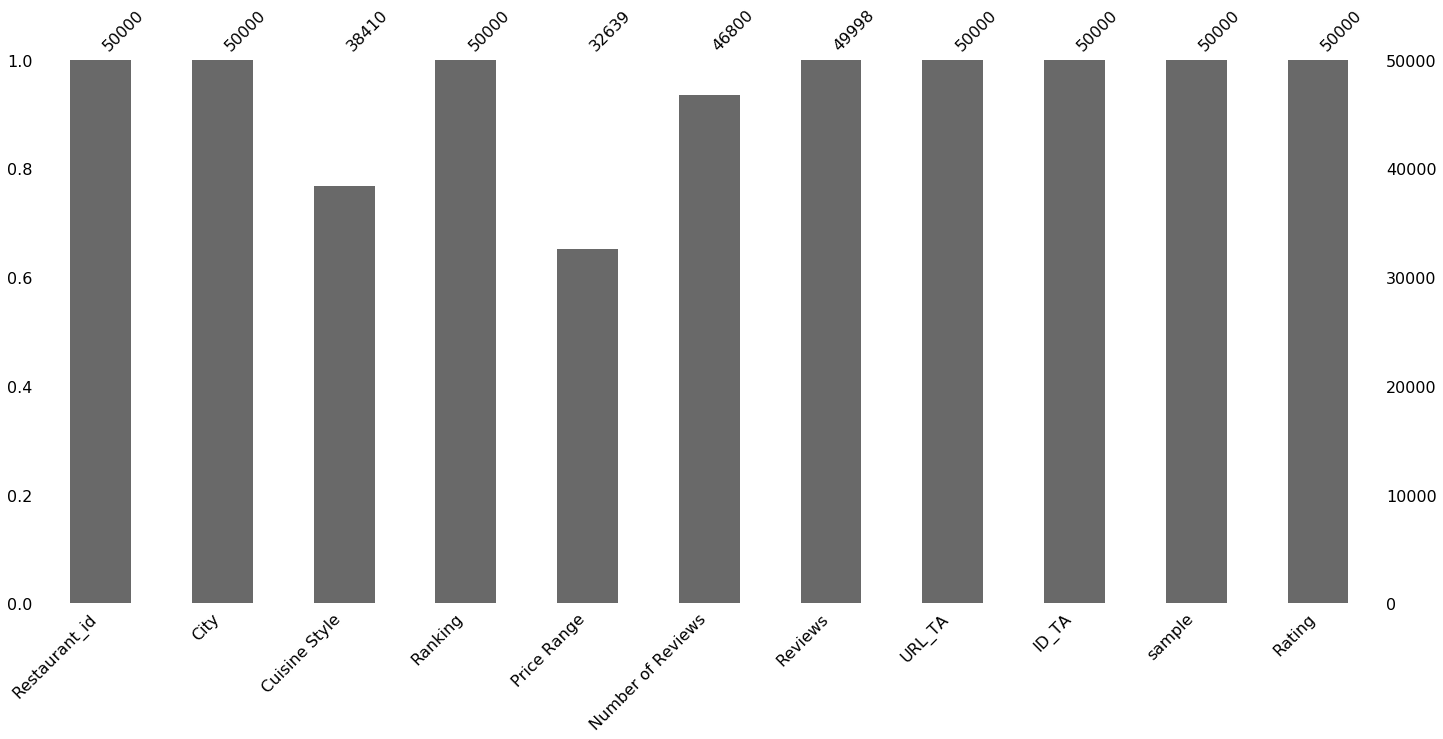

In [9]:
msno.bar(df)

In [10]:
df.columns = ['id', 'city', 'cuisine', 'ranking', 'price_range',
              'num_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating']

# Preprocessing Data

## 1. ID

In [11]:
# turning id to numeric format

df.id = df.id.apply(lambda x: x.split('_')[1]).astype(int)

### 1.2 FRANCHISE

In [12]:
# some of restaurants ids meets in dataset several times
# creating franchise feature

franchise = df[df['id'].isin(df['id'].value_counts()[
                             df['id'].value_counts() >= 2].index)]
franchise['franchise'] = 1
df['franchise'] = franchise['franchise']
df['franchise'] = df['franchise'].fillna(0)
df.franchise = df.franchise.astype(int)

## 2. CITY

### 2.1 NUMBER OF RESTAURANTS IN EACH CITY

In [13]:
restaurants_in_city = df.city.value_counts()
df['restaurants_count'] = df.city.apply(lambda x: restaurants_in_city[x])

### 2.2 CAPITAL

In [14]:
is_capital = {'London': 1, 'Paris': 1, 'Madrid': 1, 'Barcelona': 0,
              'Berlin': 1, 'Milan': 0, 'Rome': 1, 'Prague': 1,
              'Lisbon': 1, 'Vienna': 1, 'Amsterdam': 1, 'Brussels': 1,
              'Hamburg': 0, 'Munich': 0, 'Lyon': 0, 'Stockholm': 1,
              'Budapest': 1, 'Warsaw': 1, 'Dublin': 1, 'Copenhagen': 1,
              'Athens': 1, 'Edinburgh': 1, 'Zurich': 1, 'Oporto': 0,
              'Geneva': 1, 'Krakow': 1, 'Oslo': 1, 'Helsinki': 1,
              'Bratislava': 1, 'Luxembourg': 1, 'Ljubljana': 1}

In [15]:
df['capital'] = df['city'].apply(lambda x: 0 if is_capital[x] == 0 else 1)

### 2.3 POPULATION IN EACH CITY

In [16]:
population = {'Paris': 2.141, 'Stockholm': 0.973, 'London': 8.9, 'Berlin': 3.748,
              'Munich': 1.456, 'Oporto': 0.214, 'Milan': 1.352, 'Bratislava': 0.424,
              'Vienna': 1.889, 'Rome': 2.873, 'Barcelona': 5.515, 'Madrid': 6.55,
              'Dublin': 1.361, 'Brussels': 0.174, 'Zurich': 0.403, 'Warsaw': 1.708,
              'Budapest': 1.75, 'Copenhagen': 0.602, 'Amsterdam': 0.822, 'Lyon': 0.513,
              'Hamburg': 1.822, 'Lisbon': 0.505, 'Prague': 1.319, 'Oslo': 0.673,
              'Helsinki': 0.632, 'Edinburgh': 0.482, 'Geneva': 0.495, 'Ljubljana': 0.28,
              'Athens': 0.664, 'Luxembourg': 0.602, 'Krakow': 0.769}

In [17]:
df['population'] = df['city'].map(population)

## 3. RANKING

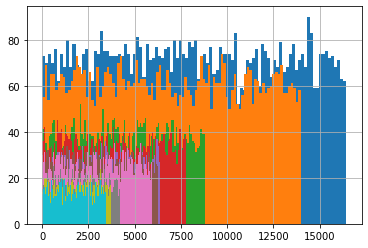

In [18]:
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

### 3.1 NORMALIZED RANKING (BY CITY)

In [19]:
ranking_by_city = df.groupby(['city'])['ranking'].mean()
restaurants_in_city = df['city'].value_counts(ascending=False)
df['ranking_by_city'] = df['city'].apply(lambda x: ranking_by_city[x])
df['restaurants_in_city'] = df['city'].apply(lambda x: restaurants_in_city[x])
df['norm_ranking'] = (df['ranking'] - df['ranking_by_city']
                      ) / df['restaurants_in_city']

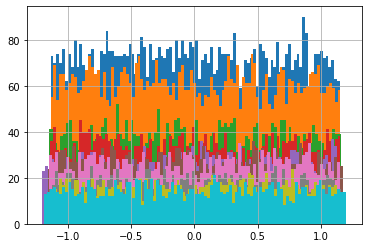

In [20]:
for x in (df['city'].value_counts())[0:10].index:
    df['norm_ranking'][df['city'] == x].hist(bins=100)
plt.show()

### 3.2 NORMALIZED MAXIMUM RANKING (BY CITY)

In [21]:
ranking_by_city_max = df.groupby(['city'])['ranking'].max()
df['ranking_by_city_max'] = df['city'].apply(lambda x: ranking_by_city_max[x])
df['norm_ranking_max'] = (
    df['ranking'] - df['ranking_by_city']) / df['ranking_by_city_max']

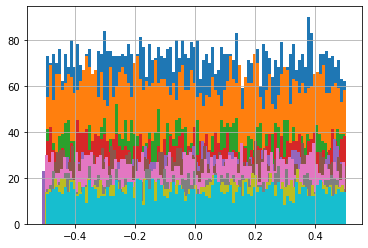

In [22]:
for x in (df['city'].value_counts())[0:10].index:
    df['norm_ranking_max'][df['city'] == x].hist(bins=100)
plt.show()

### 3.3 NORMALIZED RANKING (BY POPULATION)

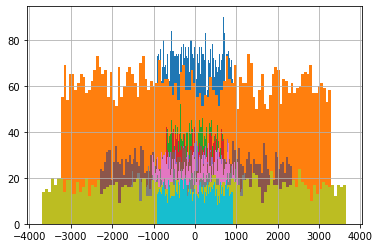

In [23]:
df['norm_ranking_pop'] = (
    df['ranking'] - df['ranking_by_city']) / df['population']

for x in (df['city'].value_counts())[0:10].index:
    df['norm_ranking_pop'][df['city'] == x].hist(bins=100)
plt.show()

## 4. CUISINE

In [24]:
df['cuisine'] = df.apply(lambda x: x['cuisine'].replace('[', '').replace(']', '').replace(
    "'", '').replace(' ', '') if type(x['cuisine']) != float else x['cuisine'], axis=1)

In [25]:
df['cuisine_isna'] = pd.isna(df['cuisine'])
df.cuisine = df.cuisine.fillna('Other')

### 4.1 NUMBER OF CUISINES IN EACH RESTAURANT

In [26]:
df['cuisines_count'] = df['cuisine'].str.split(',').str.len().fillna(1)

### 4.2 VEGETARIAN AND OTHER SPECIAL MENUS IN EACH RESTAURANT

In [27]:
df['special_menu'] = 0

In [28]:
special = ['VegetarianFriendly', 'VeganOptions', 'GlutenFreeOptions']

for option in special:
    for i in range(0, len(df)):
        if option in df.cuisine[i]:
            df.special_menu[i] = 1
        else:
            df.special_menu[i] = 0

In [29]:
cuisines = df['cuisine'].str.get_dummies(
    ',').sum().sort_values(ascending=False)
top_cuisines = [x for x in cuisines.index if cuisines[x] < 1000]


df = df.join(df['cuisine'].str.get_dummies(
    ',').drop(top_cuisines, axis=1), how='left')

## 5. PRICE RANGE

In [30]:
price_range_dict = {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}

In [31]:
df['price_range_isna'] = df.price_range.isna()
df.price_range = df.price_range.map(price_range_dict)

### 5.1 MOST COMMON PRICE BY CITY

In [32]:
price_in_city_dict = df.groupby('city')['price_range'].mean().to_dict()

In [33]:
df['price_in_city'] = df.city.map(price_in_city_dict)

## 6. NUMBER OF REVIEWS

In [34]:
df['num_of_reviews_isna'] = df.num_of_reviews.isna()
df.num_of_reviews = df.num_of_reviews.fillna(0)

## 7. REVIEWS

In [35]:
# getting date of reviews and turning it to datetime format

df.reviews = df.reviews.apply(lambda x: x.replace(
    '[[], []]', 'NaN') if type(x) != float else 'NaN')
df['reviews'] = df['reviews'].apply(lambda x: str(x) if type(x) == list else x)
res = []
for i in df['reviews']:
    res.append(re.findall(r'(\d\d/\d\d/\d\d\d\d)', i))
reviews = pd.DataFrame(res)
reviews[0] = pd.to_datetime(reviews[0])
reviews[1] = pd.to_datetime(reviews[1])

# finding newness of last review

newest_review = []

for i in range(len(reviews)):
    if reviews.loc[i, 0] > reviews.loc[i, 1]:
        newest_review.append(current_date - reviews.loc[i, 0])
    elif reviews.loc[i, 0] < reviews.loc[i, 1]:
        newest_review.append(current_date - reviews.loc[i, 1])
    else:
        newest_review.append(0)

### 7.1 NEWEST REVIEW

In [36]:
df['newest_review'] = pd.Series(newest_review)
df['newest_review'] = df['newest_review'].apply(
    lambda x: x.days if (type(x) != int) else 0)

In [37]:
df.reviews = df.reviews.apply(lambda x: np.nan if x == 'NaN' else x)

df['reviews_isna'] = df.reviews.isna()
df.reviews = df.reviews.fillna(0)

# DROP

In [38]:
df.drop(['id_ta', 'url_ta', 'reviews', 'cuisine'], axis=1, inplace=True)

# CORRELATION

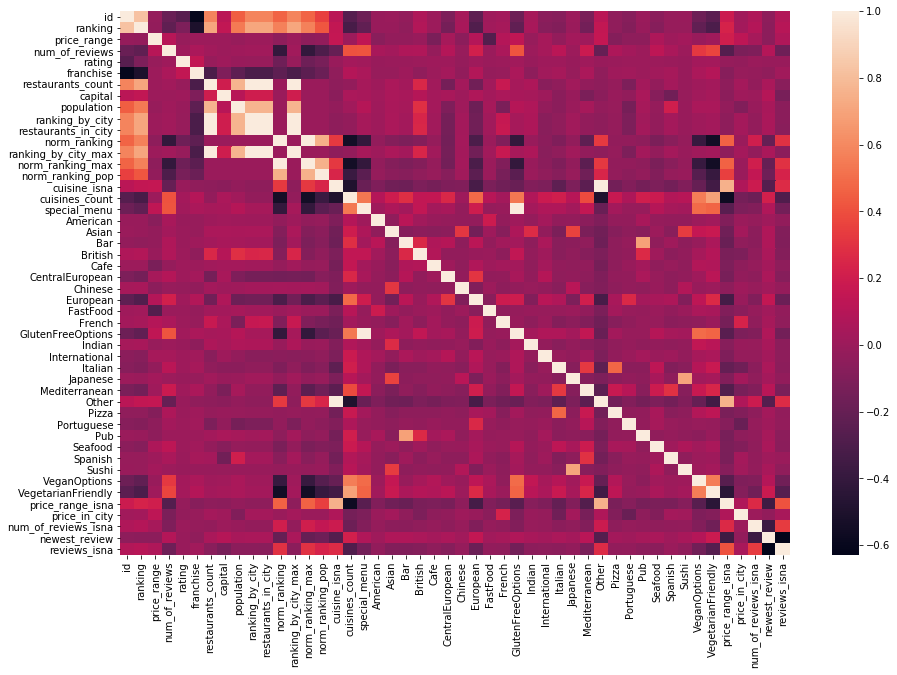

In [39]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df.drop(['sample'], axis=1).corr())

# MODEL

In [40]:
df = pd.get_dummies(df, columns=['city'])

In [52]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)

y = train_data.rating.values
X = train_data.drop(['rating'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed)

In [53]:
train_data.shape, X.shape, X_train.shape, X_test.shape

((40000, 69), (40000, 68), (32000, 68), (8000, 68))

In [54]:
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=random_seed)

In [55]:
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [56]:
y_pred

array([4.305, 4.825, 4.23 , ..., 4.575, 4.33 , 4.03 ])

In [57]:
y_pred_round = []
for item in y_pred:
    y_pred_round.append(round(item/0.5)*0.5)
y_pred_round = np.asarray(y_pred_round)

In [58]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.1739375


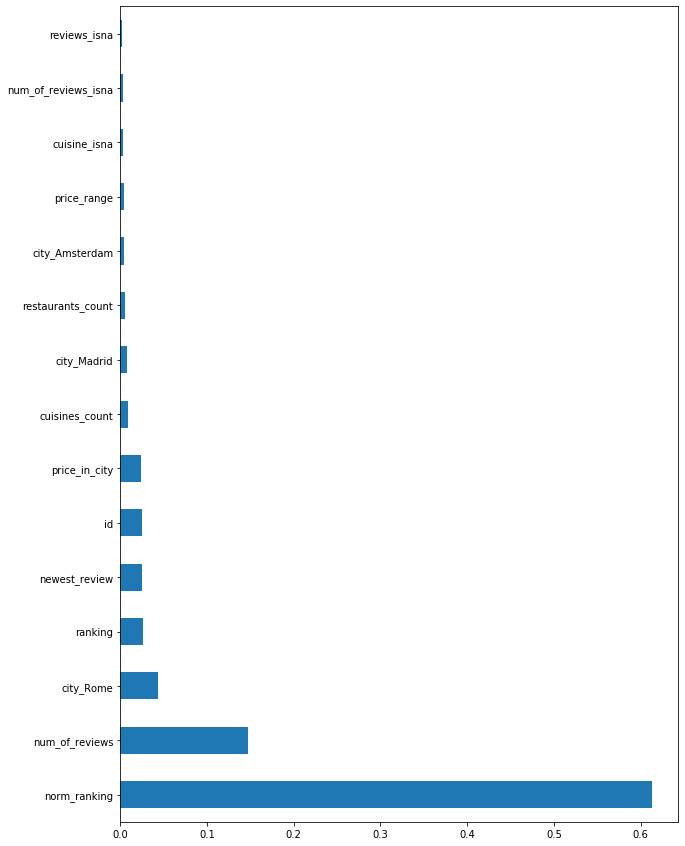

In [59]:
plt.rcParams['figure.figsize'] = (10, 15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# SUBMISSION

In [60]:
test_data = df.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['rating'], axis=1)

predict_submission = model.predict(test_data)


predict_submission_round = []
for item in predict_submission:
    predict_submission_round.append(round(item/0.5)*0.5)
predict_submission_round = np.asarray(predict_submission_round)

sample_submission['Rating'] = predict_submission_round
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
